# Handling the data

importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

Importing the flotation plant dataset and getting an overview  

In [2]:
df = pd.read_csv("MiningProcess_Flotation_Plant_Database.csv")
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


getting general information about the data set

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date                          737453 non-null  object
 1   % Iron Feed                   737453 non-null  object
 2   % Silica Feed                 737453 non-null  object
 3   Starch Flow                   737453 non-null  object
 4   Amina Flow                    737453 non-null  object
 5   Ore Pulp Flow                 737453 non-null  object
 6   Ore Pulp pH                   737453 non-null  object
 7   Ore Pulp Density              737453 non-null  object
 8   Flotation Column 01 Air Flow  737453 non-null  object
 9   Flotation Column 02 Air Flow  737453 non-null  object
 10  Flotation Column 03 Air Flow  737453 non-null  object
 11  Flotation Column 04 Air Flow  737453 non-null  object
 12  Flotation Column 05 Air Flow  737453 non-null  object
 13 

Converting the date column from object to datetime and the remaining columns to float in order to better manipulate and analyze data.

In [4]:
# Transforma a data em datetime

df['date'] = pd.to_datetime(df['date'])

# Transforma as variáveis em float

for col in df.columns[1:]:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)
    

checking the change

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          737453 non-null  datetime64[ns]
 1   % Iron Feed                   737453 non-null  float64       
 2   % Silica Feed                 737453 non-null  float64       
 3   Starch Flow                   737453 non-null  float64       
 4   Amina Flow                    737453 non-null  float64       
 5   Ore Pulp Flow                 737453 non-null  float64       
 6   Ore Pulp pH                   737453 non-null  float64       
 7   Ore Pulp Density              737453 non-null  float64       
 8   Flotation Column 01 Air Flow  737453 non-null  float64       
 9   Flotation Column 02 Air Flow  737453 non-null  float64       
 10  Flotation Column 03 Air Flow  737453 non-null  float64       
 11  Flotation Col

We are interested in the last column variable "% Silica Concentrate", so lets have a look in its plot.

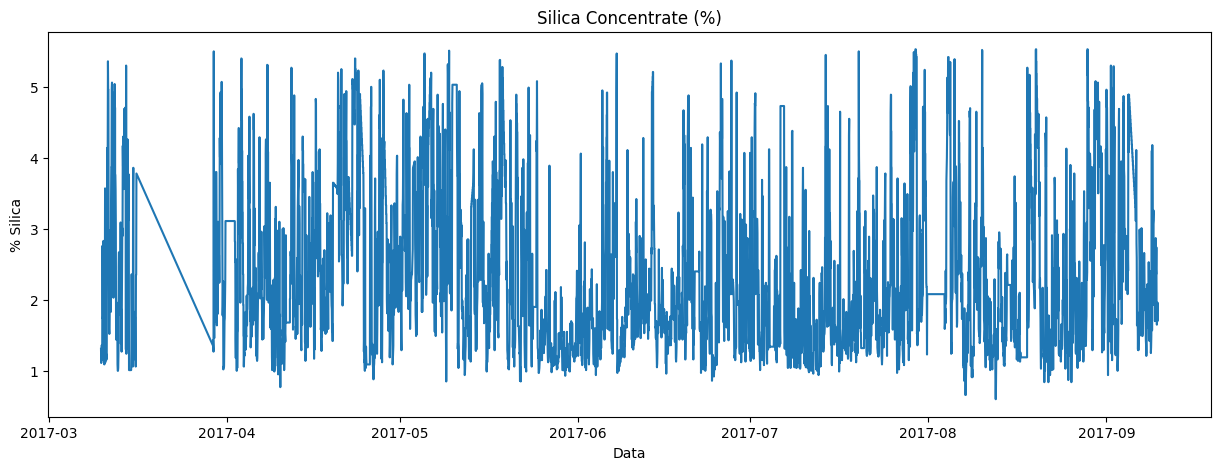

In [6]:
# Plotando a variável alvo

TARGET = '% Silica Concentrate'

plt.figure(figsize=(15,5))
plt.plot(df['date'], df[TARGET])
plt.title('Silica Concentrate (%)')
plt.xlabel('Data')
plt.ylabel('% Silica')
plt.savefig("graphs/silica_plot.png", dpi=300, bbox_inches="tight")
plt.show()

We identify a large period where the target variable seems to have changed linearly (from the middle to the end of march) which indicates a gap/interpolation in the data set. So lets check it out.

In [7]:
# Checando gaps nas horas


# conta quantas vezes cada data (ano/mes/dia/hora) se repete
hourly_counts = (
    df.set_index('date')
      .resample('h')
      .size()
      .rename('count')
)

# os dados são medidos a cada 20 segundos, portanto:
EXPECTED_PER_HOUR = 60*60/20

# obtendo as horas diferentes do esperado
hourly_anomalies = hourly_counts[hourly_counts != EXPECTED_PER_HOUR]

# informações relevantes
total_hours = len(hourly_counts)
num_anomalous_hours = len(hourly_anomalies)
num_missing_hours = (hourly_counts == 0).sum()

# printando as informações 
print(f"Total de horas: {total_hours}")
print(f"# Horas anômalas: {num_anomalous_hours} (das quais {num_missing_hours} estão faltando)")
print("Horas anômalas:")
print(hourly_anomalies)

Total de horas: 4415
# Horas anômalas: 320 (das quais 318 estão faltando)
Horas anômalas:
date
2017-03-10 01:00:00    174
2017-03-16 06:00:00      0
2017-03-16 07:00:00      0
2017-03-16 08:00:00      0
2017-03-16 09:00:00      0
                      ... 
2017-03-29 08:00:00      0
2017-03-29 09:00:00      0
2017-03-29 10:00:00      0
2017-03-29 11:00:00      0
2017-04-10 00:00:00    179
Name: count, Length: 320, dtype: int64


Indeed the hours between 2017-03-16 06:00:00 and 2017-03-29 11:00:00 are missing. Since the period before this gap is short, i decided to cut it off and analyze only the data from 2017-03-29 12:00:00 onwards.

In [8]:
# Excluindo dados anteriores ao gap

cutoff = pd.Timestamp('2017-03-29 12:00:00')
df = df[df['date'] >= cutoff]


For some reason, the timestamp "2017-04-10 00:00:00" is missing one value. So im duplicating the first occurrence of this timestamp to ensure all dates have 180 entries.

In [9]:
# Adicionando uma linha no Timestamp com 179 (2017-04-10 00:00:00)

target_time = pd.Timestamp('2017-04-10 00:00:00')

# obtendo a primeira posição com o target_time
mask = (df['date'] == target_time).to_numpy()
pos = np.flatnonzero(mask)
p = pos[0]

# duplicando a linha
df = pd.concat([df.iloc[:p+1], df.iloc[[p]], df.iloc[p+1:]], axis=0)

No more anomalous hours in the resulting data frame!

In [10]:
# conta quantas vezes cada data (ano/mes/dia/hora) se repete
hourly_counts = (
    df.set_index('date')
      .resample('h')
      .size()
      .rename('count')
)

# obtendo as horas diferentes do esperado
hourly_anomalies = hourly_counts[hourly_counts != EXPECTED_PER_HOUR]

# informações relevantes
total_hours = len(hourly_counts)
num_anomalous_hours = len(hourly_anomalies)


# printando as informações 
print(f"Total de horas: {total_hours}")
print(f"# Horas anômalas: {num_anomalous_hours}")

Total de horas: 3948
# Horas anômalas: 0


Now, lets investigate which variables change every 20 secs and which are hourly

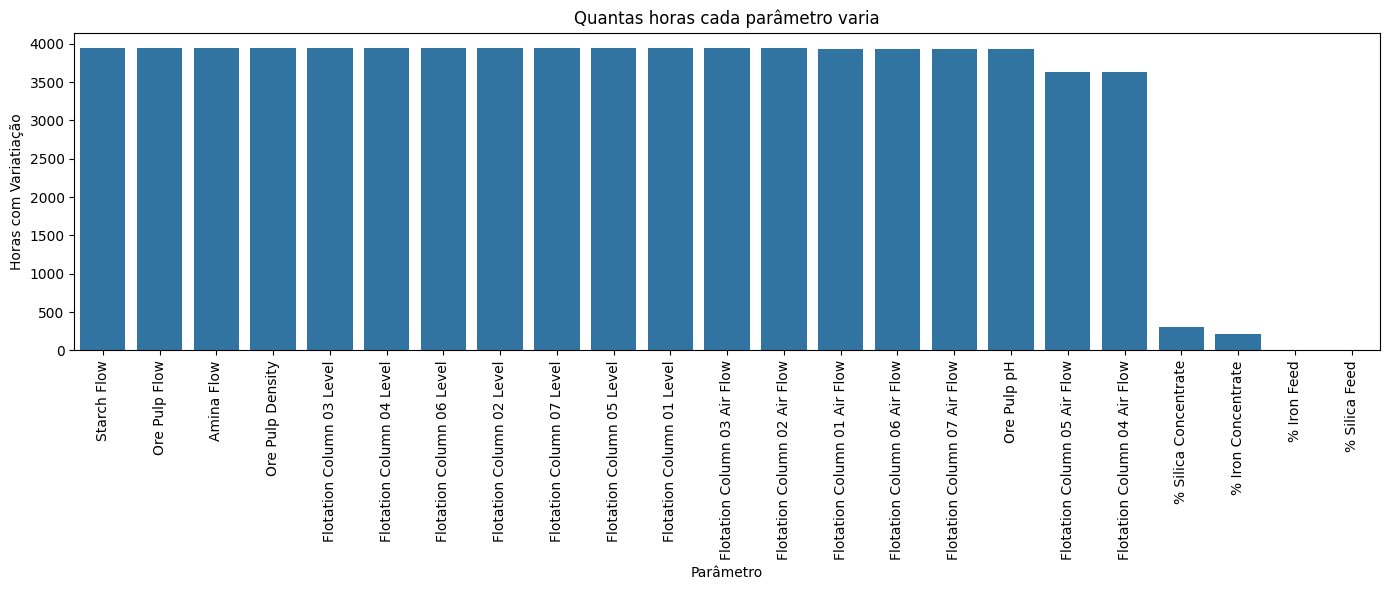

In [11]:
# Distinguindo variáveis estáticas e dinâmicas  

cols = [c for c in df.columns if c != 'date']


# # de valores únicos de cada coluna em cada data
per_hour_nunique = (
    df
    .groupby('date')[cols]
    .nunique()
)

# separando variáveis estáticas e dinâmicas 
static_every_hour = per_hour_nunique.max(axis=0) == 1
not_static_every_hour  = per_hour_nunique.max(axis=0) > 1

constant_cols = static_every_hour[static_every_hour].index.tolist()
varying_cols = not_static_every_hour[not_static_every_hour].index.tolist()

# # de horas que cada coluna varia
varies_in_how_many_hours = (per_hour_nunique > 1).sum(axis=0).sort_values(ascending=False)


# plotando
summary_df = pd.DataFrame({
    "column": cols,
    "n_hours_varying": varies_in_how_many_hours.reindex(cols).values
})

plt.figure(figsize=(14, 6), dpi=100)
sns.barplot(
    data=summary_df.sort_values("n_hours_varying", ascending=False),
    x="column",
    y="n_hours_varying",
    dodge=False,
)

plt.title("Quantas horas cada parâmetro varia")
plt.xlabel("Parâmetro")
plt.ylabel("Horas com Variatiação")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("graphs/hours_varying.png", dpi=300, bbox_inches="tight")
plt.show()

we see that '% Silica concentrate' and '% Iron concentrate' vary only in a small number of hours, so lets investigate what happens in these hours.

% Iron Concentrate varia em 215 horas
% Silica Concentrate varia em 309 horas
Ambos variam em 205 horas


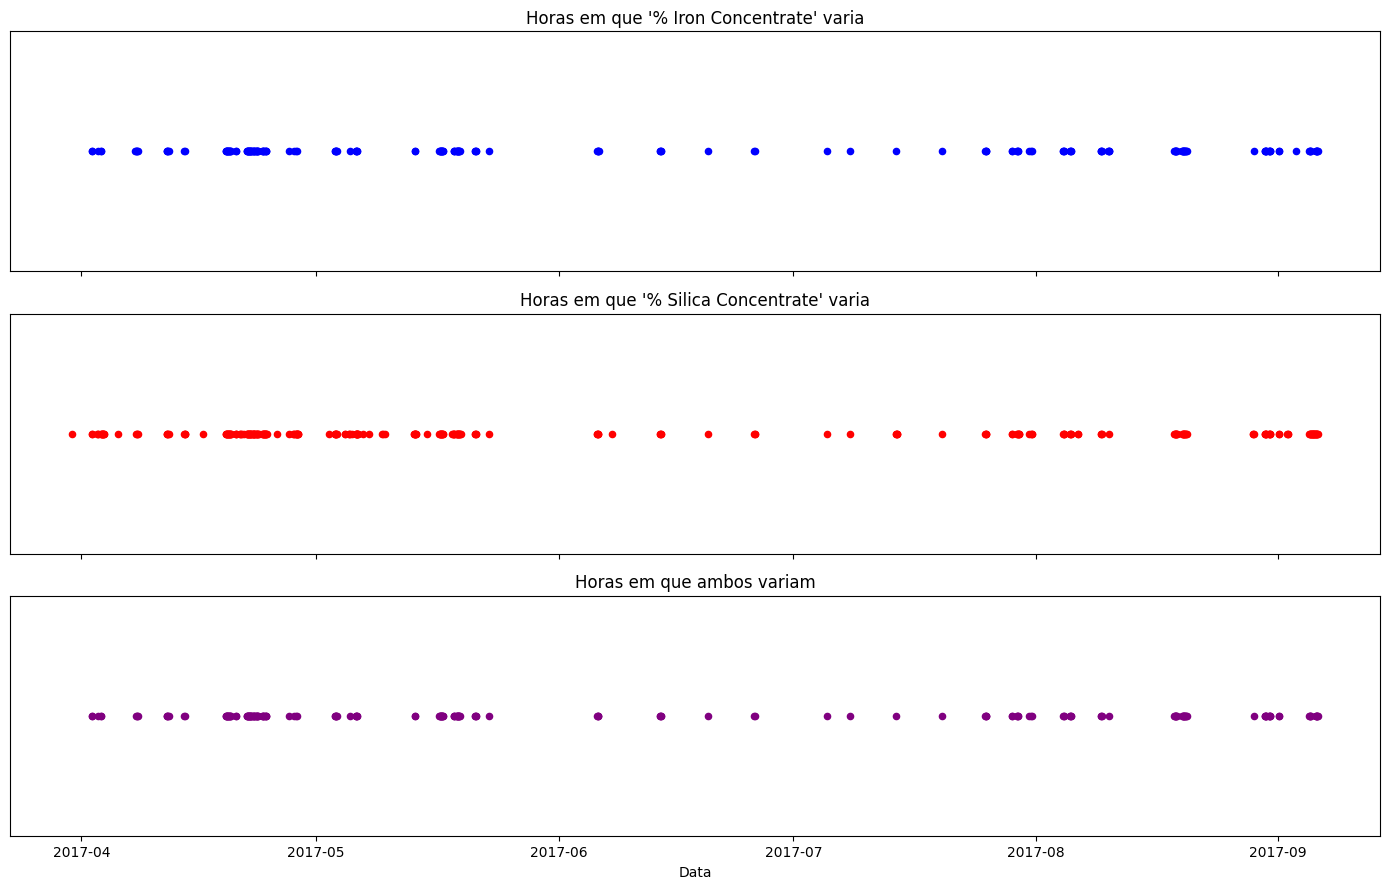

In [12]:
# Investigando as horas em que '% Iron concentrate' e '% Silica concentrate' não são estáticas

IRON = '% Iron Concentrate'

# obtem as horas que as colunas variam e sua intersessão
iron_varying_hours = per_hour_nunique.index[per_hour_nunique[IRON] > 1]
silica_varying_hours = per_hour_nunique.index[per_hour_nunique[TARGET] > 1]
both_vary_hours = iron_varying_hours.intersection(silica_varying_hours)

#printando e plotando
print(f"{IRON} varia em {len(iron_varying_hours)} horas")
print(f"{TARGET} varia em {len(silica_varying_hours)} horas")
print(f"Ambos variam em {len(both_vary_hours)} horas")

fig, axes = plt.subplots(3, 1, figsize=(14, 9), dpi=100, sharex=True)

# Ferro 
axes[0].scatter(iron_varying_hours, [0]*len(iron_varying_hours), s=20, color='blue')
axes[0].set_title(f"Horas em que '{IRON}' varia")
axes[0].set_yticks([])

# Sílica 
axes[1].scatter(silica_varying_hours, [0]*len(silica_varying_hours), s=20, color='red')
axes[1].set_title(f"Horas em que '{TARGET}' varia")
axes[1].set_yticks([])

# Ambos
axes[2].scatter(both_vary_hours, [0]*len(both_vary_hours), s=20, color='purple')
axes[2].set_title("Horas em que ambos variam")
axes[2].set_yticks([])

plt.xlabel("Data")
plt.tight_layout()
plt.savefig("graphs/hours_varying_iron_silica.png", dpi=300, bbox_inches="tight")
plt.show()

We note that the intersection of the hours when these variables vary is significant, suggesting these are not independent fluctuations. Let's visualize a sample of these hours to determine how the variation occurs.

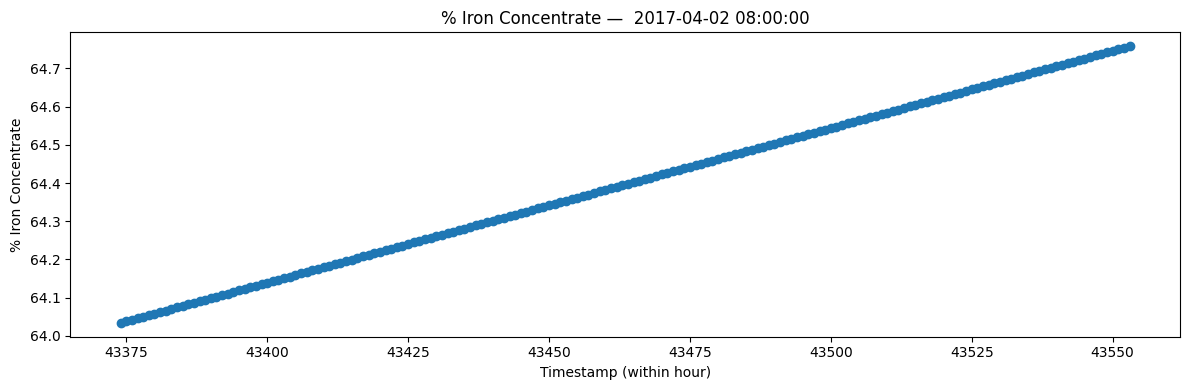

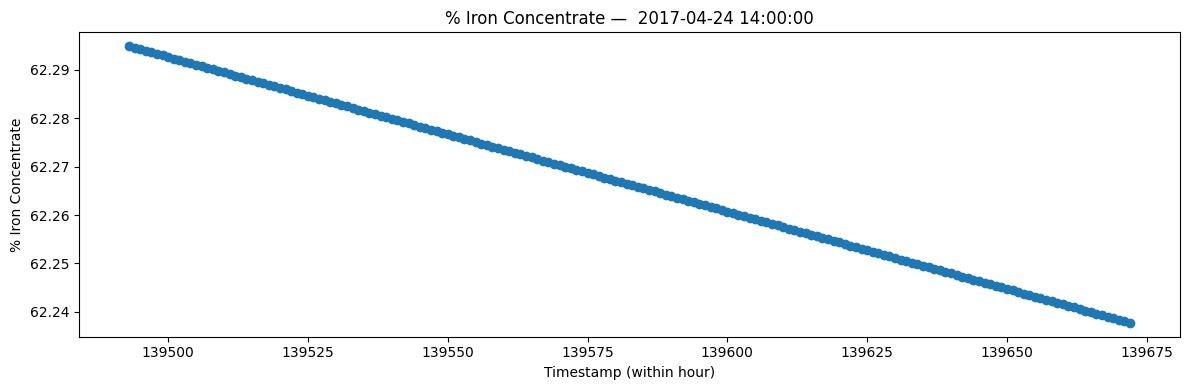

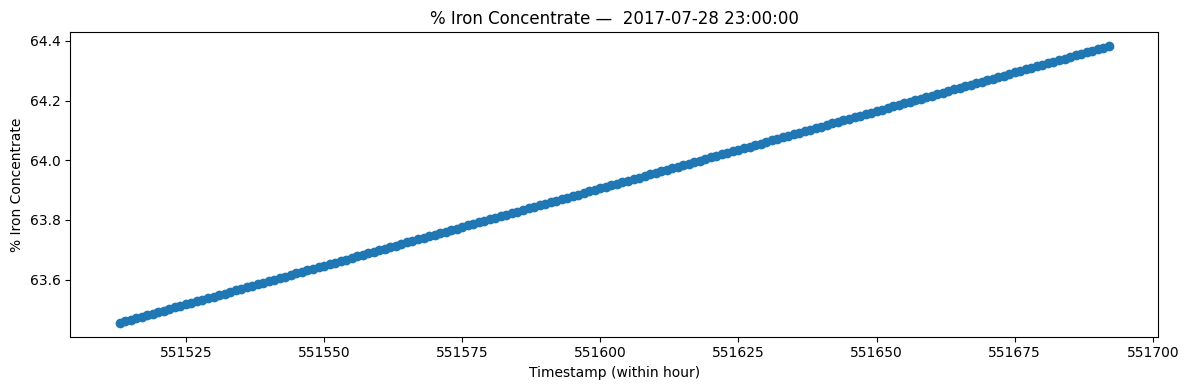

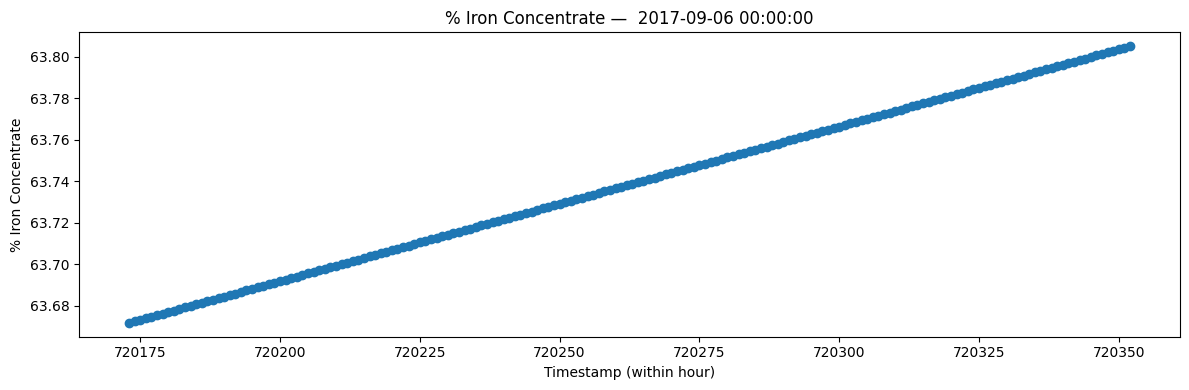

In [13]:
# Exemplos de horas em que '% Iron concentrate' varia

example_iron_hours = iron_varying_hours[:: max(1, len(iron_varying_hours)//3)]

for i, h in enumerate(example_iron_hours):

    # hora em que a coluna varia
    subset = df[df['date'] == h]
    
    # plota a variação
    plt.figure(figsize=(12,4), dpi=100)
    plt.plot(subset.index, subset[IRON], marker='o', lw=1)
    plt.title(f"{ IRON} —  {h}")
    plt.xlabel("Timestamp (within hour)")
    plt.ylabel(IRON)
    plt.tight_layout()
    plt.savefig(f"graphs/example_hours_iron_varying_{i+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

The sample we choose to analyze some of hours when '% Iron Concentrate' vary indicates an linear progression, denoting an interpolation.

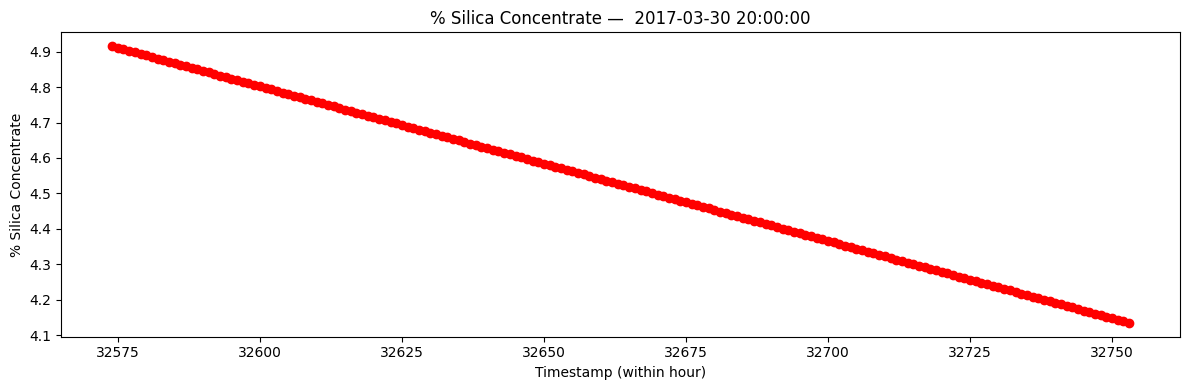

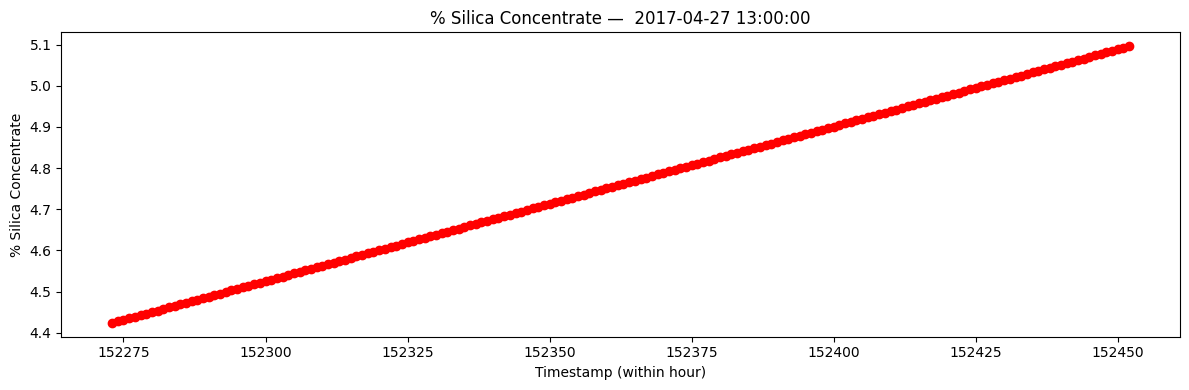

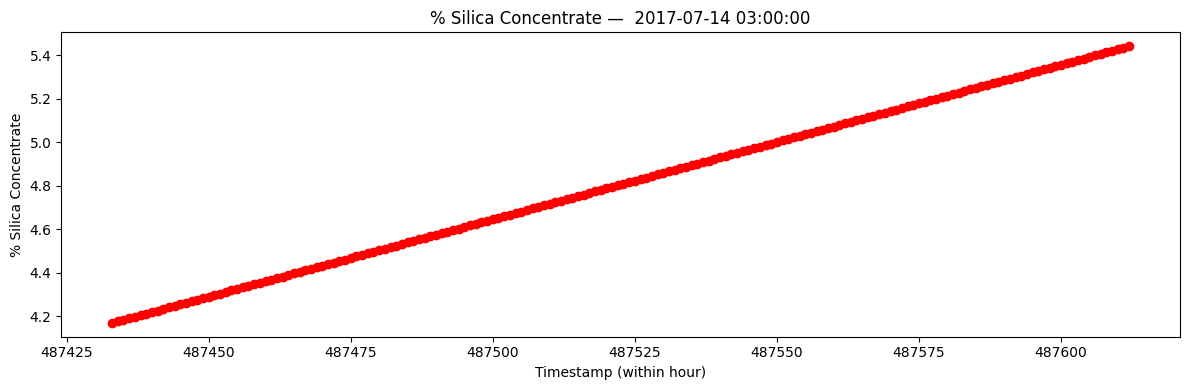

In [14]:
# Exemplos de horas em que '% Silica concentrate' varia

example_silica_hours = silica_varying_hours[:: max(1, len(silica_varying_hours)//3)]


for i, h in enumerate(example_silica_hours):

    # hora em que a coluna varia
    subset = df[df['date'] == h]
    
    # plota a variação
    plt.figure(figsize=(12,4), dpi=100)
    plt.plot(subset.index, subset[ TARGET], marker='o', lw=1, color = 'red')
    plt.title(f"{ TARGET} —  {h}")
    plt.xlabel("Timestamp (within hour)")
    plt.ylabel( TARGET)
    plt.tight_layout()
    plt.savefig(f"graphs/example_hours_silica_varying_{i+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

A visual inspection of the hours where '% Silica Concentrate' varies also shows a linear progression. This confirms that the variable is not being sampled in real-time at 20-second intervals; instead, the hourly values are being linearly interpolated to fill the high-frequency timestamps. Therefore, these variable are actually static.

In [15]:
# Define as variáveis '% Silica concentrate' e '% Iron concentrate' como estàticas em vez de dinâmicas

varying_cols.remove(TARGET)
varying_cols.remove(IRON)
constant_cols.append(TARGET)
constant_cols.append(IRON)

# printando variáveis estáticas e dinâmicas
print("\nParameters constant within EVERY complete hour (hourly/static fields):")
print(constant_cols)
print("\nParameters varying within complete hours (high-frequency sensors):")
print(varying_cols)


Parameters constant within EVERY complete hour (hourly/static fields):
['% Iron Feed', '% Silica Feed', '% Silica Concentrate', '% Iron Concentrate']

Parameters varying within complete hours (high-frequency sensors):
['Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow', 'Flotation Column 07 Air Flow', 'Flotation Column 01 Level', 'Flotation Column 02 Level', 'Flotation Column 03 Level', 'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level']


With that in mind, I decided to aggregate the dataframe to an hourly frequency to align our features with the target variable (% Silica Concentrate), which only updates once per hour. By averaging the dinamic variables, I am filtering out short-term sensor noise and ensuring each row represents a distinct operational state that directly corresponds to a unique quality measurement.

In [16]:
# Tranforma o Dataframe em horário 

target_cols = [IRON, TARGET]

# a data se torna o indice
df = df.set_index('date')

# intervalos de uma hora fechados à esquerda
rule = 'h'
kw   = dict(label='left', closed='left')


# média das variáveis dinâmicas, primeiro valor das variáveis concentrate e com delay para feed
varying_mean   = df[varying_cols].resample(rule, **kw).mean().shift(1)
feed_variables = df[constant_cols].resample(rule, **kw).first().shift(1).drop(columns=target_cols)
concentrate_variables = df[constant_cols].resample(rule, **kw).first()[target_cols]


# concatena as três partes
df_hourly = pd.concat([feed_variables, varying_mean, concentrate_variables], axis=1)

Now, lets have a look on our new data frame.

In [17]:
df_hourly.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.44,1.36
2017-03-29 13:00:00,60.18,9.34,1060.859297,379.836203,400.982539,9.527187,1.550374,200.035839,195.577700,199.983717,...,249.992956,753.724247,726.559437,860.557818,477.349197,452.512522,478.219647,470.105547,66.57,1.43
2017-03-29 14:00:00,60.18,9.34,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.106250,199.765344,...,250.059711,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,66.64,1.33
2017-03-29 15:00:00,60.18,9.34,1435.425811,474.656322,399.157083,9.687788,1.645200,200.019311,195.604928,199.925800,...,250.111328,851.951492,776.293654,879.704989,456.147231,453.227000,447.708467,453.475667,66.41,1.27
2017-03-29 16:00:00,60.18,9.34,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,200.044339,...,250.028506,855.910630,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,63.63,5.50


Now we introduce a new variable called 'Silica_Delta' that indicates the difference of our TARGET in the last two rows

In [18]:
df_hourly['Silica_Delta'] = df_hourly[TARGET].diff().shift(1)

df_hourly.dropna(inplace=True)

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,Silica_Delta
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 14:00:00,60.18,9.34,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.106250,199.765344,...,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,66.64,1.33,0.07
2017-03-29 15:00:00,60.18,9.34,1435.425811,474.656322,399.157083,9.687788,1.645200,200.019311,195.604928,199.925800,...,851.951492,776.293654,879.704989,456.147231,453.227000,447.708467,453.475667,66.41,1.27,-0.10
2017-03-29 16:00:00,60.18,9.34,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,200.044339,...,855.910630,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,63.63,5.50,-0.06
2017-03-29 17:00:00,59.54,9.56,1367.502858,317.134072,400.836283,9.936163,1.530984,199.878922,196.162864,199.905467,...,851.603513,784.446084,884.840698,450.123050,451.774694,451.574422,449.406894,66.19,1.64,4.23
2017-03-29 18:00:00,59.54,9.56,1729.412710,410.978717,400.036094,9.477018,1.567739,199.906183,195.235633,200.027594,...,847.602240,803.198299,869.178824,431.977917,452.877969,462.790350,449.586028,66.26,1.46,-3.86


Finally, we notice that the variables '% Iron Feed' and '% Silica Feed' as well as '% Iron Concentrate' and '% Silica Concentrate' are highly correlated.

In [19]:
print(df_hourly['% Iron Feed'].corr(df_hourly['% Silica Feed']))
print(df_hourly['% Iron Concentrate'].corr(df_hourly['% Silica Concentrate']))

-0.972032003192329
-0.8034778545333618


So we drop '% Iron Concentrate' and the Feed variable less correlated with our TARGET in order to avoid redundancy.

In [20]:
correlations = df_hourly[['% Iron Feed', '% Silica Feed', '% Silica Concentrate']].corr()

print(correlations['% Silica Concentrate'])

% Iron Feed            -0.079645
% Silica Feed           0.075270
% Silica Concentrate    1.000000
Name: % Silica Concentrate, dtype: float64


In [21]:
df_hourly.drop(columns=['% Silica Feed', '% Iron Concentrate'], inplace=True)

In [22]:
df_hourly.head()

,% Iron Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate,Silica_Delta
date,,,,,,,,,,,,,,,,,,,,,
2017-03-29 14:00:00,60.18,2034.926525,322.233975,400.468947,9.700679,1.532017,199.990122,195.106250,199.765344,295.096,...,250.059711,848.675503,777.784437,869.419421,483.816131,469.448172,471.607075,462.665478,1.33,0.07
2017-03-29 15:00:00,60.18,1435.425811,474.656322,399.157083,9.687788,1.645200,200.019311,195.604928,199.925800,295.096,...,250.111328,851.951492,776.293654,879.704989,456.147231,453.227000,447.708467,453.475667,1.27,-0.10
2017-03-29 16:00:00,60.18,618.460387,396.377733,398.942522,9.851689,1.559929,199.940833,195.657094,200.044339,295.096,...,250.028506,855.910630,780.369869,882.093896,449.410744,448.581506,450.697578,448.660094,5.50,-0.06
2017-03-29 17:00:00,59.54,1367.502858,317.134072,400.836283,9.936163,1.530984,199.878922,196.162864,199.905467,295.096,...,250.122067,851.603513,784.446084,884.840698,450.123050,451.774694,451.574422,449.406894,1.64,4.23
2017-03-29 18:00:00,59.54,1729.412710,410.978717,400.036094,9.477018,1.567739,199.906183,195.235633,200.027594,295.096,...,250.053183,847.602240,803.198299,869.178824,431.977917,452.877969,462.790350,449.586028,1.46,-3.86


Our target variable plot on the new data.

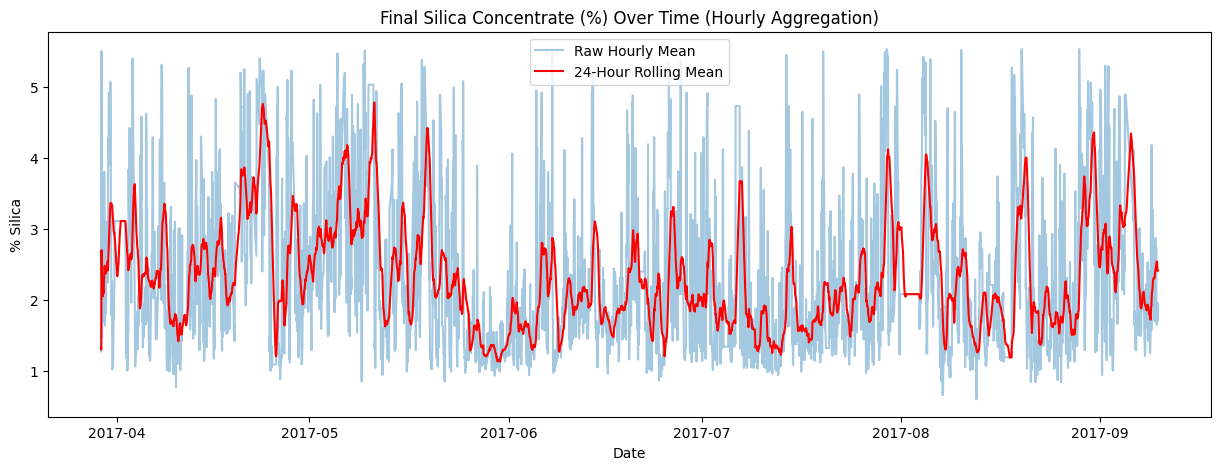

In [23]:
# Plotando a variável alvo

plt.figure(figsize=(15,5))
plt.plot(df_hourly.index, df_hourly[TARGET], alpha=0.4, label='Raw Hourly Mean')
df_hourly['silica_smooth'] = df_hourly[TARGET].rolling(window=24, min_periods=1).mean()
plt.plot(df_hourly.index, df_hourly['silica_smooth'], color='red', label='24-Hour Rolling Mean')
plt.title('Final Silica Concentrate (%) Over Time (Hourly Aggregation)')
plt.xlabel('Date')
plt.ylabel('% Silica')
plt.legend()
plt.savefig("graphs/hourly_silica_plot.png", dpi=300, bbox_inches="tight")
plt.show()

df_hourly = df_hourly.drop(columns=['silica_smooth'])

## Features

I've created dosage features by dividing reagent flows by the total ore mass (Flow × Density). This normalizing the chemicals to the amount of rock being processed.

In [24]:
# Features

AMINE = 'Amina Flow'
PULP_FLOW = 'Ore Pulp Flow'
PULP_DENSITY = 'Ore Pulp Density'
STARCH = 'Starch Flow'


df_hourly['True_Amine_Dosage'] = df_hourly[AMINE] / (df_hourly[PULP_FLOW] * df_hourly[PULP_DENSITY]).replace(0, np.nan)
df_hourly['True_Starch_Dosage'] = df_hourly[STARCH] / (df_hourly[PULP_FLOW] * df_hourly[PULP_DENSITY]).replace(0, np.nan)

In [25]:
# Realocando as colunas

col = df_hourly.pop('True_Starch_Dosage')
df_hourly.insert(1, 'True_Starch_Dosage', col)
col = df_hourly.pop('True_Amine_Dosage')
df_hourly.insert(2, 'True_Amine_Dosage', col)

Now lets see how the new features correlate with our target variable compared with the old ones.

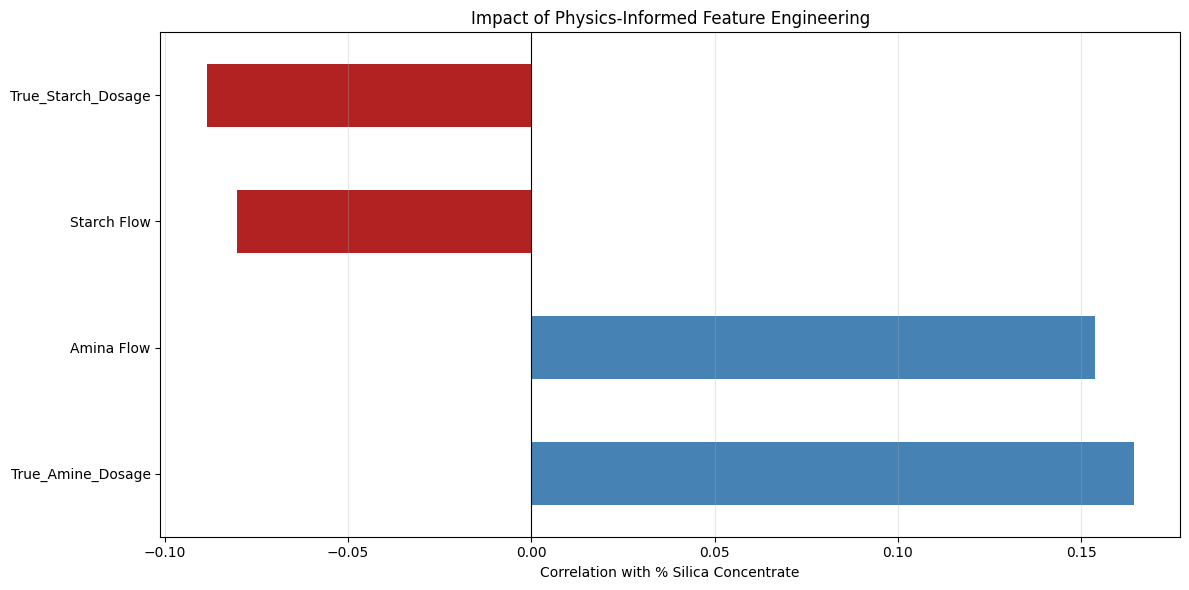

In [26]:
# Calculate correlation with Silica

comparison_cols = [
    STARCH,
    AMINE,  
    'True_Amine_Dosage',
    'True_Starch_Dosage'
]

correlations = df_hourly[comparison_cols + [TARGET]].corr()[TARGET].drop(TARGET)
correlations = correlations.sort_values(ascending=False)

# Plotando as correlações

plt.figure(figsize=(12, 6))
colors = ['firebrick' if x < 0 else 'steelblue' for x in correlations.values]
correlations.plot(kind='barh', color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Impact of Physics-Informed Feature Engineering')
plt.xlabel('Correlation with % Silica Concentrate')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("graphs/physics_feature_importance.png", dpi=300)
plt.show()

As we could verify, indeed the new features correlate more with our target variable than the old ones. Now lets see how they correlate among themselves to se if they are redundant.

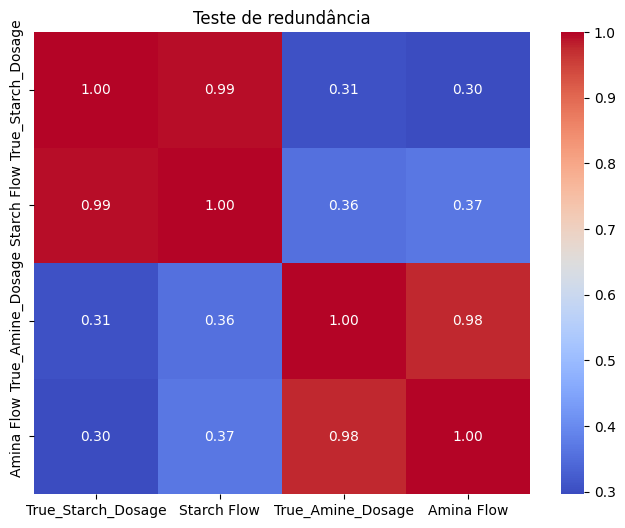

In [27]:
# Correlação das features novas com as originais

comp_starch = ['True_Starch_Dosage', STARCH]
comp_amina = ['True_Amine_Dosage', AMINE ]

check_cols = comp_starch + comp_amina
corr_matrix = df_hourly[check_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Teste de redundância")
plt.savefig("graphs/Redundancy Check.png", dpi=300)
plt.show()

As expected, the old features are highly correlated with the new ones. So we can drop them without remorse.

In [28]:
# Dropando as variáveis originais

df_hourly.drop(columns=[AMINE], inplace=True)
df_hourly.drop(columns=[STARCH], inplace=True)

Next, we analyze the correlation among the air columns. 

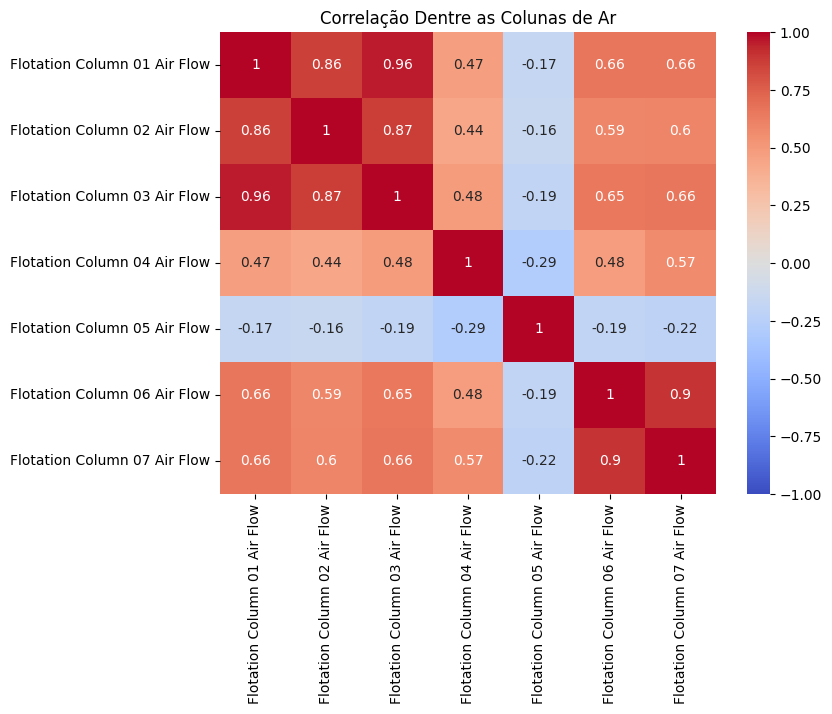

In [29]:
# Analisando a correlação entre as colunas de ar

air_cols = [c for c in cols if 'Air Flow' in c]

plt.figure(figsize=(8, 6))
sns.heatmap(df_hourly[air_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlação Dentre as Colunas de Ar")
plt.savefig("graphs/columns_air_correlation.png", dpi=300)
plt.show()

The correlation heatmap reveals two clusters of highly redundant columns (01 to 03 and 06-07), Since these sensors are likely measuring the same physical process, I create a single feature that represents the average of the cluster. Conversely, Column 05 shows a negative correlation with the rest of the group, suggesting it operates independently and migh be used as a column control in the process. 

In [30]:
# Agrupando colunas de ar altamente correlacionadas

group_1_cols = [air_cols[0], air_cols[1], air_cols[2]] # Cols 1, 2, 3 
group_2_cols = [air_cols[5], air_cols[6]]              # Cols 6, 7
col_4_name   = air_cols[3]                             # col 4
col_5_name   = air_cols[4]                             #col 5

df_hourly['Air_Cluster_123'] = df_hourly[group_1_cols].mean(axis=1)
df_hourly['Air_Cluster_67'] = df_hourly[group_2_cols].mean(axis=1)

In [31]:
# Realocando as colunas

col = df_hourly.pop('Air_Cluster_123')
df_hourly.insert(6, 'Air_Cluster_123', col)

col = df_hourly.pop('Air_Cluster_67')
df_hourly.insert(12, 'Air_Cluster_67', col)

In [32]:
# Dropando as colunas originais

cols_to_drop = group_1_cols + group_2_cols
df_hourly.drop(columns=cols_to_drop, inplace=True)

We make a similar treatment on the level columns

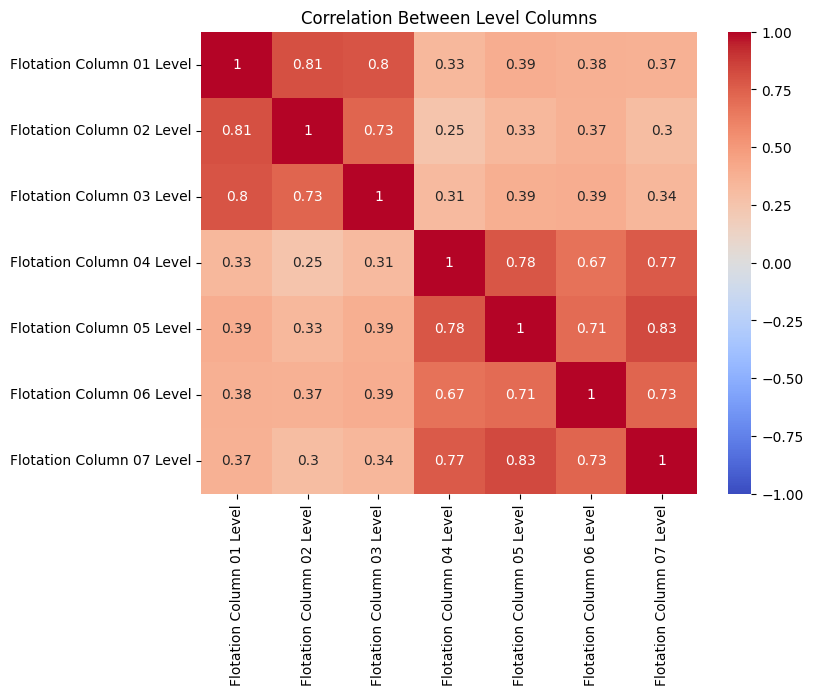

In [33]:
# Analisando a correlação entre o level das colunas

level_cols = [c for c in cols if 'Level' in c]

plt.figure(figsize=(8, 6))
sns.heatmap(df_hourly[level_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.savefig("graphs/column_level_correlation.png", dpi=300, bbox_inches="tight")
plt.title("Correlation Between Level Columns")
plt.show()

Columns 1 to 3 are highly correlated, so is 4 to 7.

In [34]:
# Agrupando level de colunas altamente correlacionados

level_cols_123 = [level_cols[0], level_cols[1], level_cols[2]]                 # cols 1, 2, 3
level_cols_4567 = [level_cols[3], level_cols[4], level_cols[5], level_cols[6]] # cols 4,5,6,7

df_hourly['Level_Cluster_123'] = df_hourly[level_cols_123].mean(axis=1)
df_hourly['Level_Cluster_4567'] = df_hourly[level_cols_4567].mean(axis=1)

In [35]:
# Realocando as colunas

col = df_hourly.pop('Level_Cluster_123')
df_hourly.insert(10, 'Level_Cluster_123', col)

col = df_hourly.pop('Level_Cluster_4567')
df_hourly.insert(11, 'Level_Cluster_4567', col)

In [36]:
# Dropando as colunas originais

df_hourly.drop(columns=level_cols_123 + level_cols_4567, inplace=True)

## Outliers

To start our outliers analyzis, lets take a look on the variables histograms to see how they are distributed.

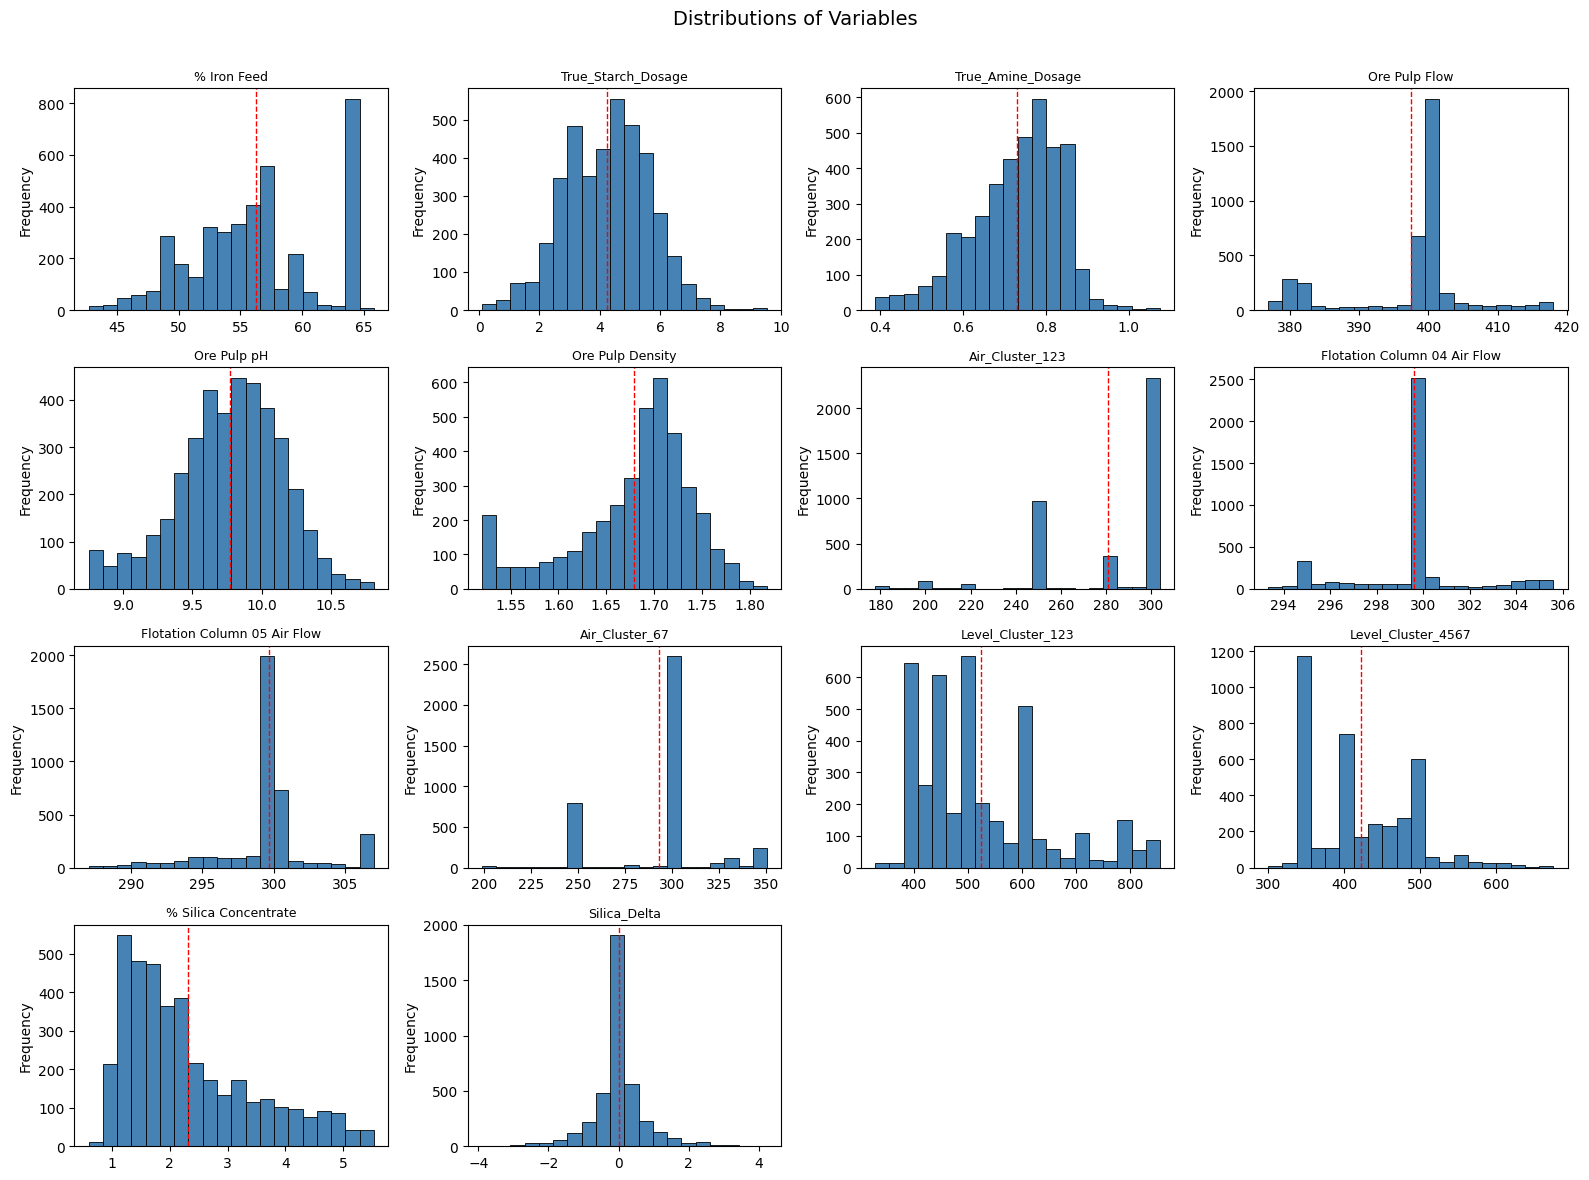

In [37]:
# Histogramas

cols = df_hourly.columns
n_cols = 4
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()
for i, col in enumerate(cols):
    ax = axes[i]
    data = df_hourly[col]
    ax.hist(data, bins=20, color='steelblue', edgecolor='black', linewidth=0.6)
    ax.set_title(col, fontsize=9)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=1)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle('Distributions of Variables', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("graphs/Histograms.png", dpi=300, bbox_inches="tight")
plt.show()

The histograms reveal that several flow and level variables follow multimodal distributions, with a high amount of outliers. These 'outliers' actually represent distinct operational states or setpoints rather than sensor errors. Conversely, the engineered dosage features exhibit near-normal distributions, confirming their suitability as stable predictors for the model.

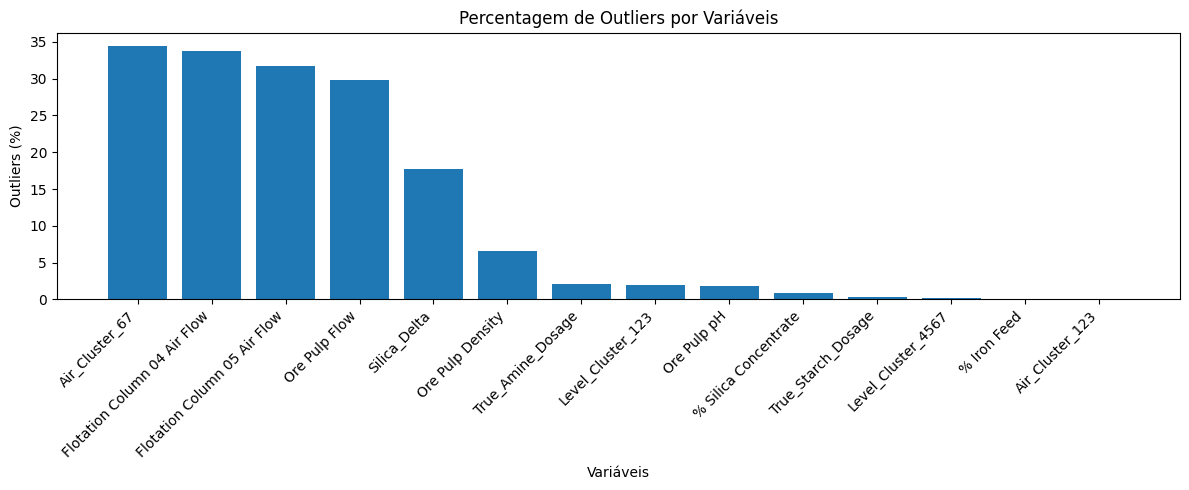

In [38]:
# Outliers

outlier_summary = []

for col in df_hourly.columns:
    s = df_hourly[col]
    
    # teste de Tuckey  
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_mask = (s < lower) | (s > upper)

    # % de outliers
    outlier_count = outlier_mask.sum()
    total = len(s)
    outlier_pct = (outlier_count / total * 100) if total > 0 else 0.0

    # insere na lista
    outlier_summary.append({
        "column": col,
        "percent_outliers": outlier_pct
    })

outlier_summary_df = (
    pd.DataFrame(outlier_summary)
      .sort_values("percent_outliers", ascending=False)
      .reset_index(drop=True)
)

# plotando
plt.figure(figsize=(12, 5))
plt.bar(outlier_summary_df["column"], outlier_summary_df["percent_outliers"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Outliers (%)")
plt.xlabel("Variáveis")
plt.title("Percentagem de Outliers por Variáveis")
plt.tight_layout()
plt.savefig("graphs/Outliers.png", dpi=300, bbox_inches="tight")
plt.show()

The outlier analysis reveals that flow-based variables exhibit high statistical variance (30-35%), likely reflecting operational shifts rather than sensor errors. Conversely, the engineered dosage features and target quality variables show high stability, suggesting they will provide a more reliable signal for the predictive model

## Trend/Sazonality

To better understand the underlying patterns in % Silica Concentrate, I performed an MSTL decomposition to isolate the long-term trend from daily and weekly seasonalities. This analysis reveals the extent to which silica fluctuations are driven by cyclical operational schedules versus erratic process shifts. The resulting residuals represent the 'unexplained' variance that our predictive model will aim to capture using the available sensor features.

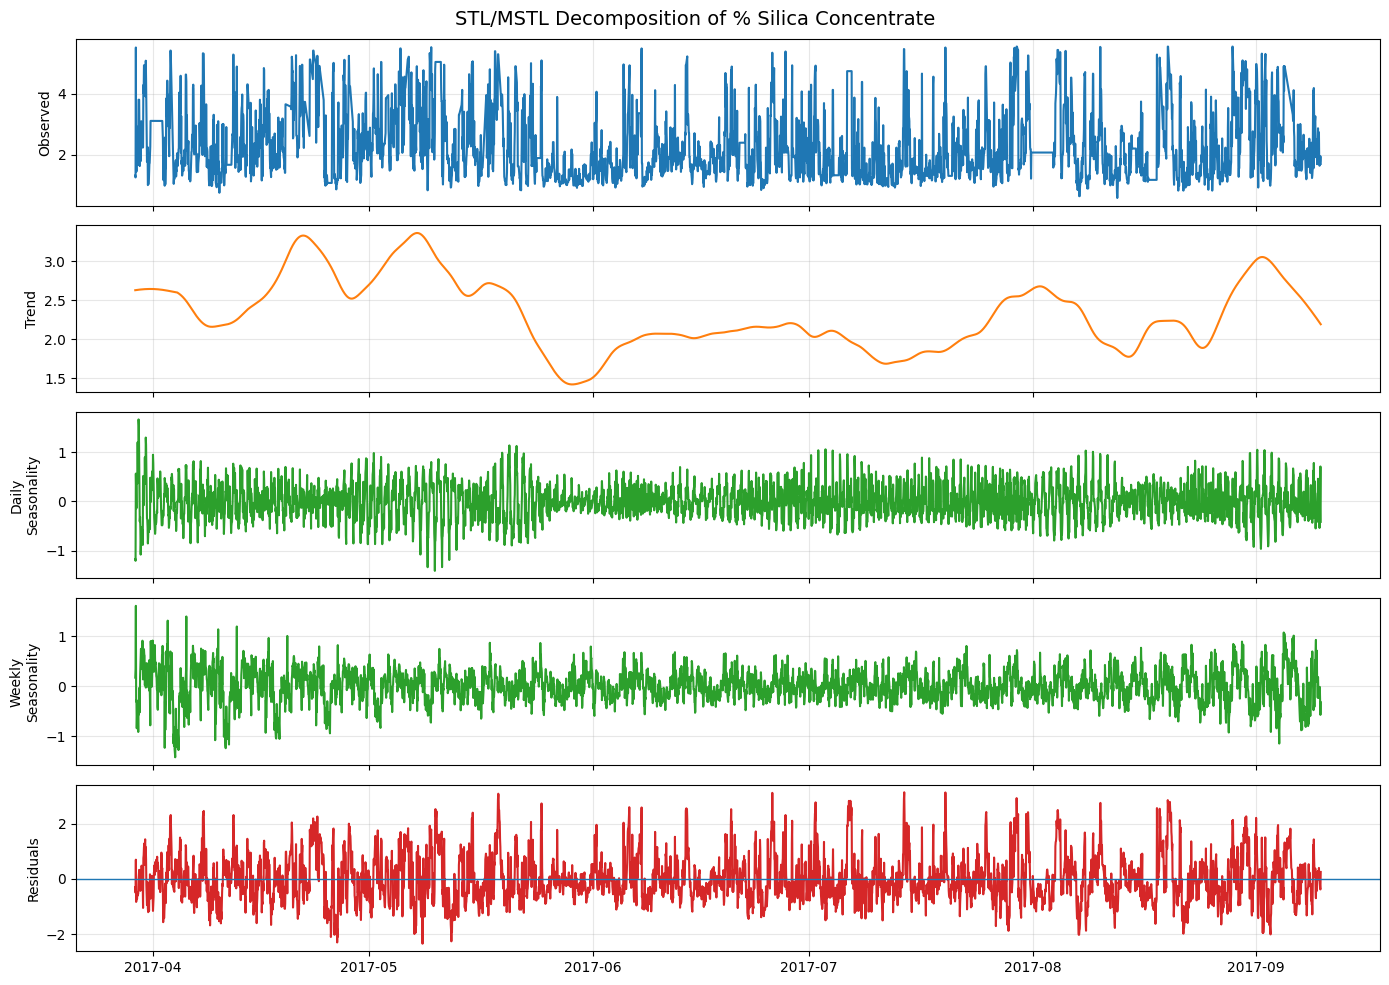

{'trend_strength': np.float64(0.244), 'daily_strength': np.float64(0.181), 'weekly_strength': np.float64(0.159)}


In [39]:
# Tendencia, sazonalidade etc

# preparando os dados
y = df_hourly[TARGET]
fit = MSTL(y, periods=(24, 168)).fit()
trend = pd.Series(fit.trend, index=y.index)

# definindo as varáveis
seas_day  = fit.seasonal.iloc[:, 0].rename('seasonal_24h')
seas_week = fit.seasonal.iloc[:, 1].rename('seasonal_168h')
resid = pd.Series(fit.resid, index=y.index)

# plotando
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=True)
axes[0].plot(y, color='tab:blue');      axes[0].set_ylabel('Observed')
axes[1].plot(trend, color='tab:orange');axes[1].set_ylabel('Trend')
axes[2].plot(seas_day, color='tab:green');axes[2].set_ylabel('Daily\nSeasonality')
axes[3].plot(seas_week, color='tab:green');axes[3].set_ylabel('Weekly\nSeasonality')
axes[4].plot(resid, color='tab:red');   axes[4].axhline(0, lw=1); axes[4].set_ylabel('Residuals')
for ax in axes: ax.grid(alpha=0.3)
fig.suptitle(f'STL/MSTL Decomposition of {TARGET}', fontsize=14)
plt.tight_layout()
plt.savefig("graphs/MSTL.png", dpi=300, bbox_inches="tight")
plt.show()

# calculando a força das tendências
Fs_day  = 1 - resid.var(ddof=0) / (resid.add(seas_day, fill_value=0).var(ddof=0))
Fs_week = 1 - resid.var(ddof=0) / (resid.add(seas_week, fill_value=0).var(ddof=0))
Ft      = 1 - resid.var(ddof=0) / (resid.add(trend,    fill_value=0).var(ddof=0))

# printando
print({'trend_strength': round(Ft,3), 'daily_strength': round(Fs_day,3), 'weekly_strength': round(Fs_week,3)})

The MSTL decomposition of % Silica Concentrate reveals a target variable primarily driven by stochastic process changes rather than predictable time patterns. The silica levels do not exhibit long-term, slow-moving drifts that could be easily modeled by time alone. Furthermore, the process is largely unaffected by cyclic operational schedules or maintenance routines. Because these temporal components are weak, the majority of the variance remains in the residuals, confirming that fluctuations are likely driven by real-time industrial variables rather than simple clock-based patterns.

## Autocorrelation function

To determine how long the "memory" of the process lasts, we will now examine the Autocorrelation Function (ACF) plot. This analysis is critical for identifying whether the current silica value is influenced by its own past values, which will help us decide if including lagged features in the machine learning model is necessary to capture process momentum.

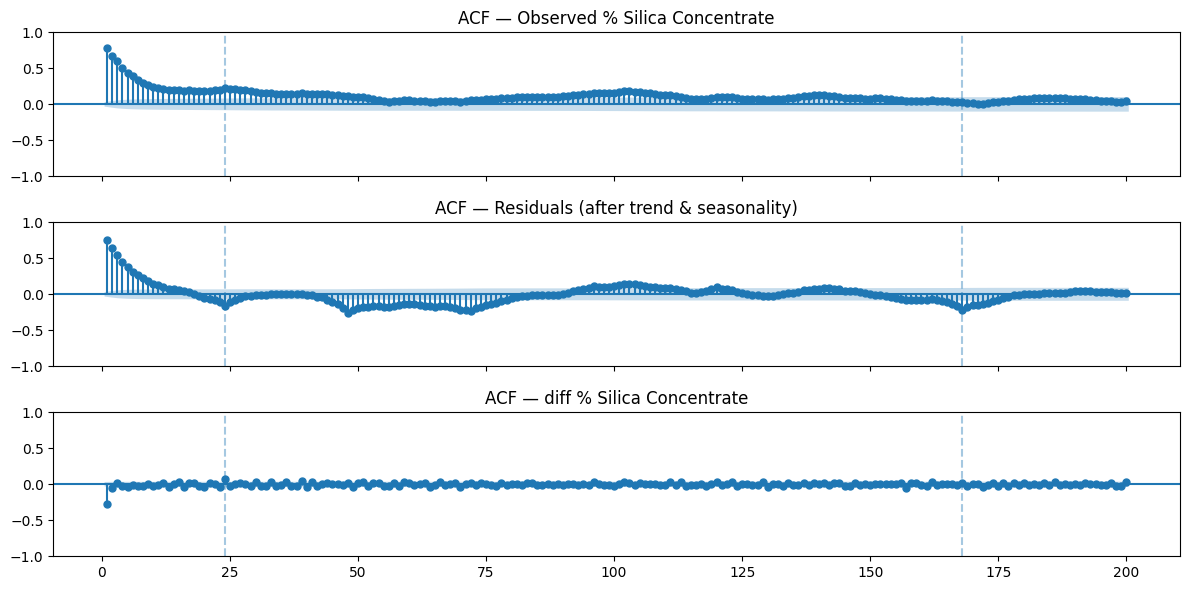

In [ ]:
# ACF

# TARGET observável
obs = pd.Series(fit.observed, index=y.index)

# # de lags
max_lags = 200

# plotando
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

# observável
plot_acf(obs.dropna(), lags=max_lags, ax=axes[0], zero=False)
axes[0].set_title("ACF — Observed % Silica Concentrate")

# residual
plot_acf(resid.dropna(), lags=max_lags, ax=axes[1], zero=False)
axes[1].set_title("ACF — Residuals (after trend & seasonality)")

for ax in axes: 
    for lag in (24, 168): 
            ax.axvline(lag, linestyle='--', alpha=0.4)
    
plt.tight_layout()
plt.savefig("graphs/ACF.png", dpi=300, bbox_inches="tight")
plt.show()

The autocorrelation analysis confirms that while the Observed silica levels exhibit high persistence and long-term memory, Differencing the data effectively removes this trend, resulting in a nearly stationary signal. The Residual ACF reveals that some minor cyclical patterns remain even after MSTL decomposition, likely corresponding to the discrete operational setpoints identified in previous steps. These results suggest that the model will benefit significantly from lagged features to capture the short-term momentum of the process.

## ADF test

To statistically validate the temporal properties of % Silica Concentrate, I conducted an Augmented Dickey-Fuller (ADF) test. This test is essential for determining if the series is stationary, meaning its mean and variance remain constant over time. If the test fails to reject the null hypothesis (typically indicated by a p-value > 0.05), it confirms that the raw silica data contains a unit root and is non-stationary. This finding justifies the use of transformations such as differencing or the inclusion of lagged features—techniques that "stabilize" the series and prevent the machine learning model from being misled by long-term drifts or spurious correlations.

In [41]:
#ADFtest

series = y.dropna()

result = adfuller(series, autolag='AIC')

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value:       {result[1]:.4f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

ADF Statistic: -7.7329
p-value:       0.0000
Critical Values:
   1%: -3.4320
   5%: -2.8623
   10%: -2.5672


The Augmented Dickey-Fuller (ADF) test results for % Silica Concentrate provide strong statistical evidence that the series is stationary. With an ADF Statistic of -7.7340 and a p-value of 0.0000, we can reject the null hypothesis of a unit root at all standard significance levels. This confirms that the mean and variance of the silica levels are stable over time, rather than exhibiting a random walk or long-term drift. From a modeling perspective, this is a significant advantage, as it allows for the use of raw target values without the need for differencing, while ensuring that the underlying data distribution remains consistent for predictive analysis

## Correlation

To identify redundant variables and understand linear relationships, we calculate the correlation matrix for all process sensors and feed characteristics. This step allows us to detect multicollinearity and select the strongest features for the predictive model.

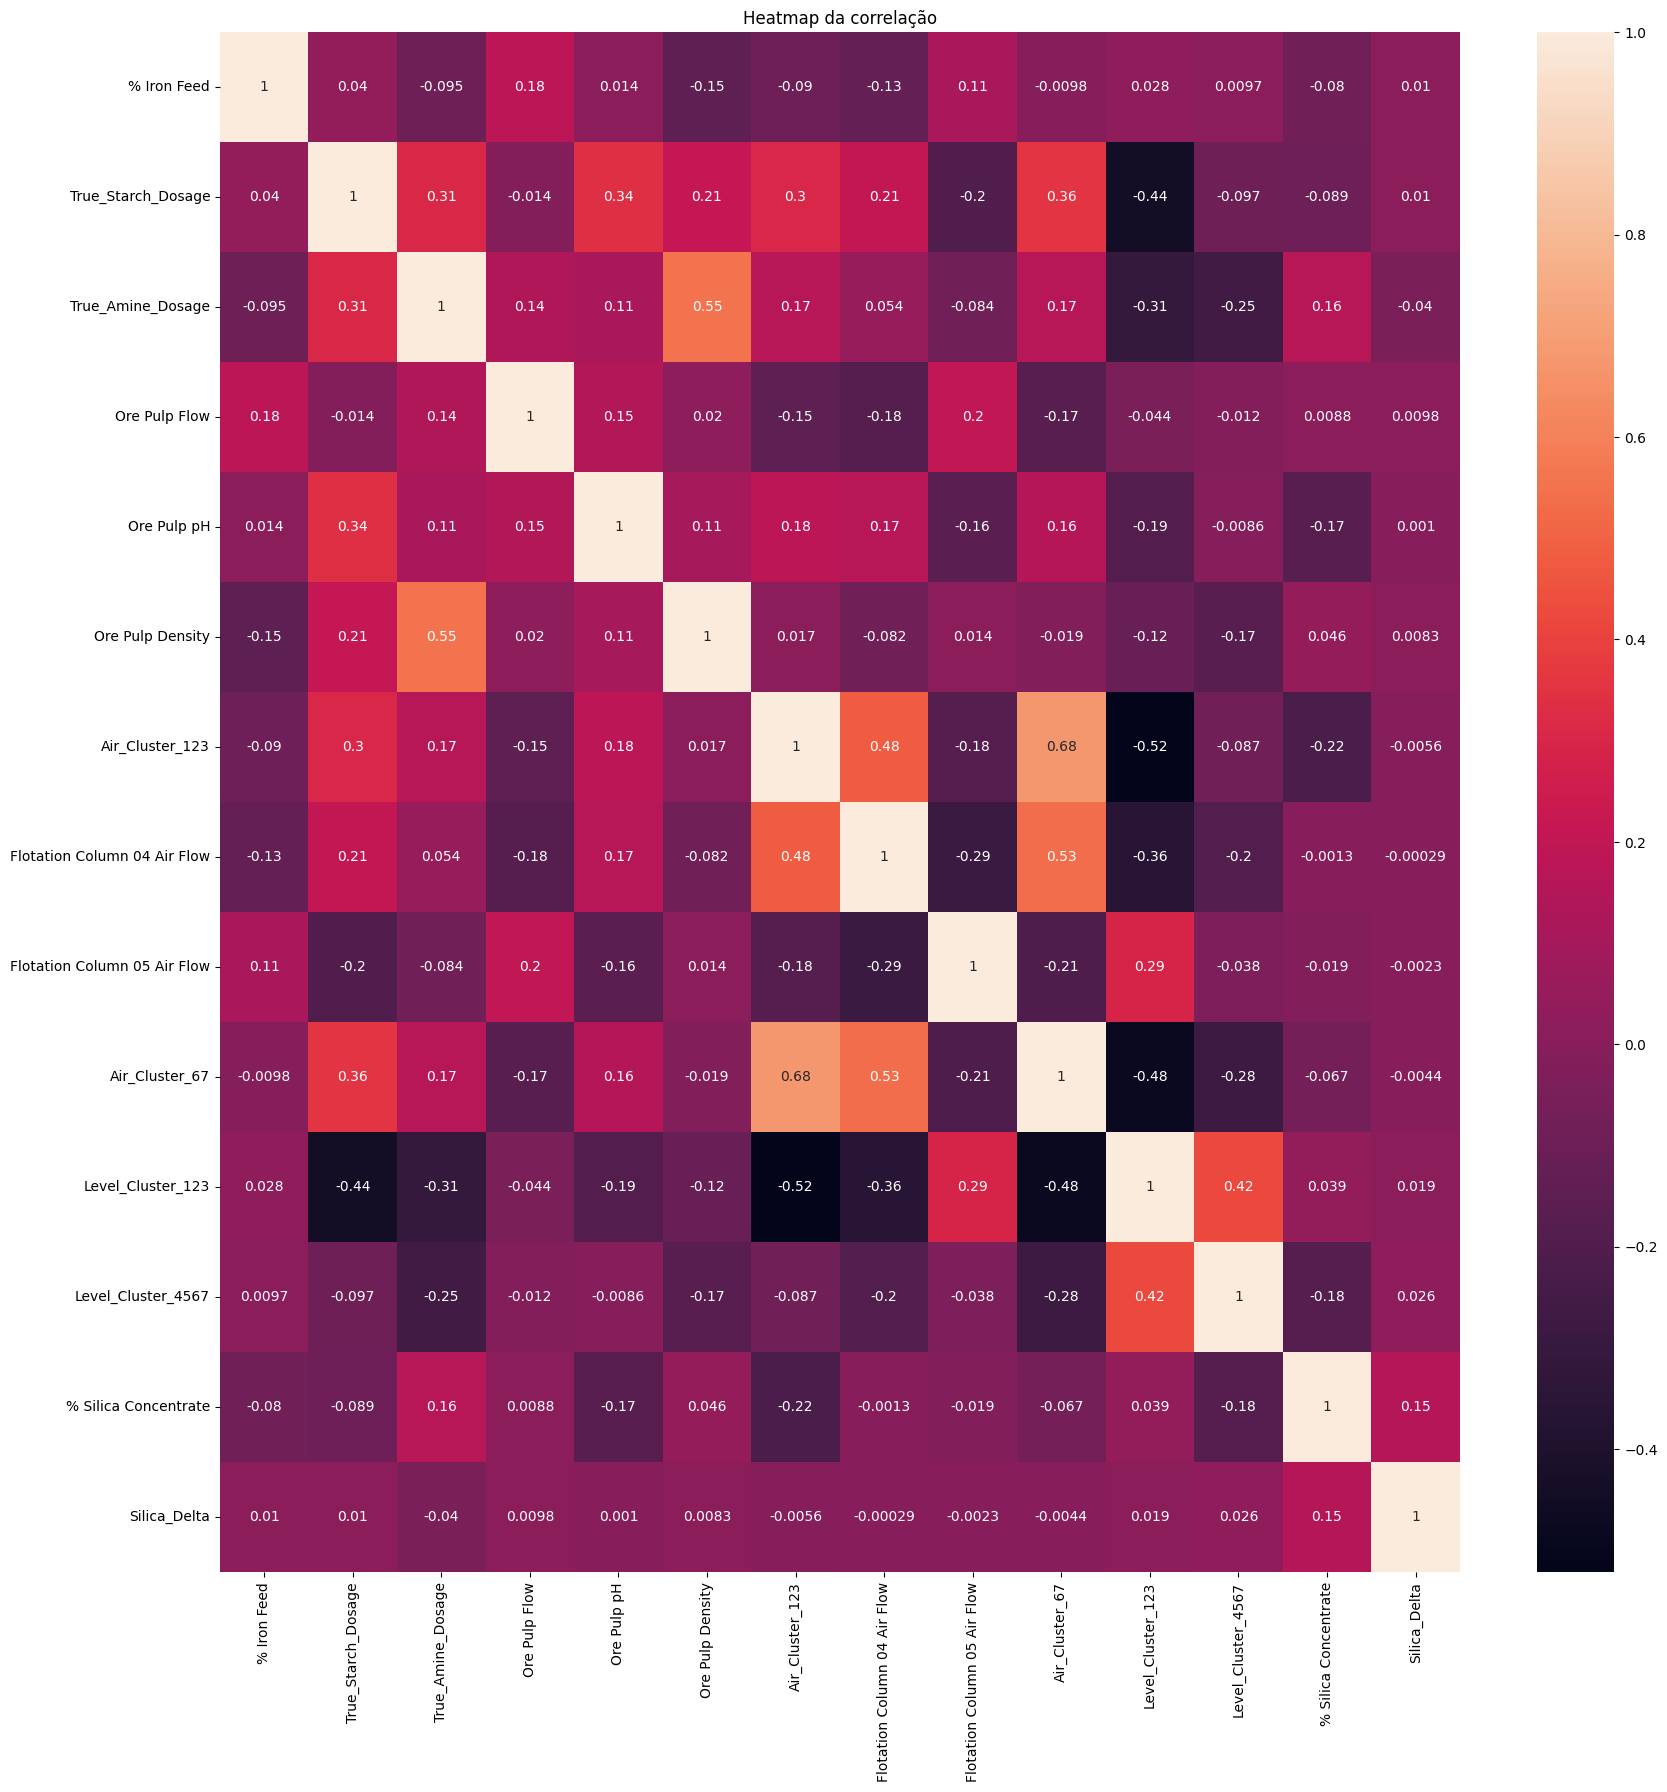

Top 5 features most correlated with % Silica Concentrate (by absolute correlation):
Air_Cluster_123      -0.219521
Level_Cluster_4567   -0.177425
Ore Pulp pH          -0.166622
True_Amine_Dosage     0.164295
Silica_Delta          0.154763
Name: % Silica Concentrate, dtype: float64


In [44]:
# Correlation

corr = df_hourly.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)
plt.title('Heatmap da correlação')
plt.savefig("graphs/Correlação.png", dpi=300, bbox_inches="tight")
plt.show()

target_corr = corr[TARGET].drop(labels=[TARGET])
top10_abs_idx = target_corr.abs().sort_values(ascending=False).head(5).index
top10_by_abs = target_corr.loc[top10_abs_idx]

print(f"Top 5 features most correlated with {TARGET} (by absolute correlation):")
print(top10_by_abs)

## PCA

We perform Principal Component Analysis (PCA) to determine if the high-dimensional sensor data can be compressed into fewer latent operating modes without losing critical information. This analysis helps visualize potential clustering of 'good' vs. 'bad' process states and assesses whether the individual sensors are measuring unique or repetitive signals.

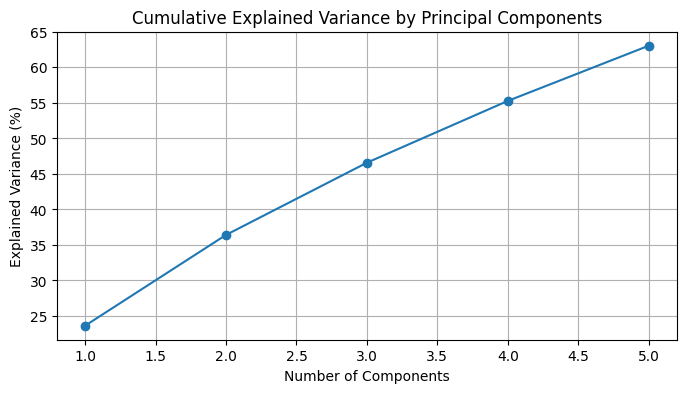

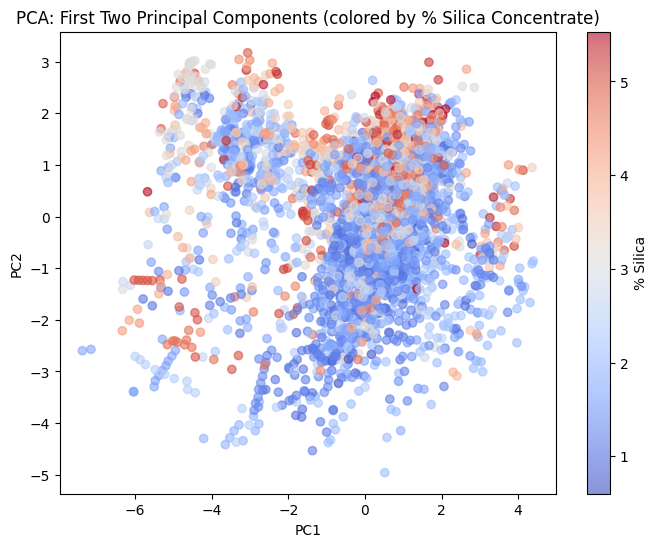

Top contributing variables to PC1:
Air_Cluster_67                  0.428619
Level_Cluster_123               0.426557
Air_Cluster_123                 0.412002
Flotation Column 04 Air Flow    0.354635
True_Starch_Dosage              0.336842
True_Amine_Dosage               0.237675
Flotation Column 05 Air Flow    0.225703
Level_Cluster_4567              0.218838
Ore Pulp pH                     0.203967
Ore Pulp Density                0.123654
Name: PC1, dtype: float64


In [45]:
# PCA

cols.drop([TARGET])
X = df_hourly[cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=5) 
principal_components = pca.fit_transform(X_scaled)


explained_var = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8,4))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance (%)')
plt.grid(True)
plt.savefig("graphs/PCA1.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(principal_components[:,0], principal_components[:,1],
            c=df_hourly.loc[X.index, TARGET], 
            cmap='coolwarm', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components (colored by % Silica Concentrate)')
plt.colorbar(label='% Silica')
plt.savefig("graphs/PCA2.png", dpi=300, bbox_inches="tight")
plt.show()

loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=cols)
print("Top contributing variables to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))

PCA results showed that over five components are required to explain the variance, indicating that the process sensors are not highly redundant. The lack of clear clustering in the primary components proves that instantaneous data alone is insufficient, validating the necessity of adding temporal lag features to the model.